Автор: Лейман М.А.  

Дата создания: 10.02.2025

# Линейная регрессия

### Датасет

In [1]:
!ls dataset

sample_submission.csv  test.csv  train.csv


### Проверка виртуальное окружение

In [53]:
!which python 

/home/maksim/develops/python/MAKSIM/.venv/bin/python


## Импорты

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Загрузка данных

In [2]:
# Загрузка данных
train_path = "dataset/train.csv"
test_path = "dataset/test.csv"

data = pd.read_csv(train_path)

# Просмотр первых строк
print(data.head().to_string(index=False))

 id  store_sales(in millions)  unit_sales(in millions)  total_children  num_children_at_home  avg_cars_at home(approx).1  gross_weight  recyclable_package  low_fat  units_per_case  store_sqft  coffee_bar  video_store  salad_bar  prepared_food  florist   cost
  0                      8.61                      3.0             2.0                   2.0                         2.0         10.30                 1.0      0.0            32.0     36509.0         0.0          0.0        0.0            0.0      0.0  62.09
  1                      5.00                      2.0             4.0                   0.0                         3.0          6.66                 1.0      0.0             1.0     28206.0         1.0          0.0        0.0            0.0      0.0 121.80
  2                     14.08                      4.0             0.0                   0.0                         3.0         21.30                 1.0      0.0            26.0     21215.0         1.0          0.0       

### 2. EDA: анализ данных

In [3]:
# 2. EDA: анализ данных
eda_summary = pd.DataFrame({
    "Признак": data.columns,
    "Пропуски (%)": data.isnull().mean() * 100,
    "Min": data.min(),
    "Max": data.max(),
    "Среднее": data.mean(),
    "Медиана": data.median(),
    "Дисперсия": data.var(),
    "Квантиль 0.1": data.quantile(0.1),
    "Квантиль 0.9": data.quantile(0.9),
    "Квартиль 1": data.quantile(0.25),
    "Квартиль 3": data.quantile(0.75)
})
print(eda_summary.to_string(index=False))


                   Признак  Пропуски (%)      Min       Max       Среднее   Медиана    Дисперсия  Квантиль 0.1  Квантиль 0.9  Квартиль 1  Квартиль 3
                        id           0.0     0.00 360335.00 180167.500000 180167.50 1.082020e+10      36033.50     324301.50    90083.75   270251.25
  store_sales(in millions)           0.0     0.51     22.92      6.337376      5.78 1.094273e+01          2.32         11.04        3.72        8.40
   unit_sales(in millions)           0.0     1.00      6.00      3.043881      3.00 6.157163e-01          2.00          4.00        3.00        4.00
            total_children           0.0     0.00      5.00      2.456482      2.00 2.217097e+00          0.00          4.00        1.00        4.00
      num_children_at_home           0.0     0.00      5.00      0.689390      0.00 1.475575e+00          0.00          3.00        0.00        1.00
avg_cars_at home(approx).1           0.0     0.00      4.00      2.203813      2.00 1.175692e+00          

### 3. Подготовка данных

In [4]:
# 3. Подготовка данных
target = "cost"
X = data.drop(columns=[target])
y = data[target]

# Обработка пропусков (заполним средним)
X.fillna(X.mean(), inplace=True)

# Анализ и обработка выбросов 
lower_bound = y.quantile(0.1)
upper_bound = y.quantile(0.9)
y = y[(y >= lower_bound) & (y <= upper_bound)]
X = X.loc[y.index]

### 4. Корреляционный анализ

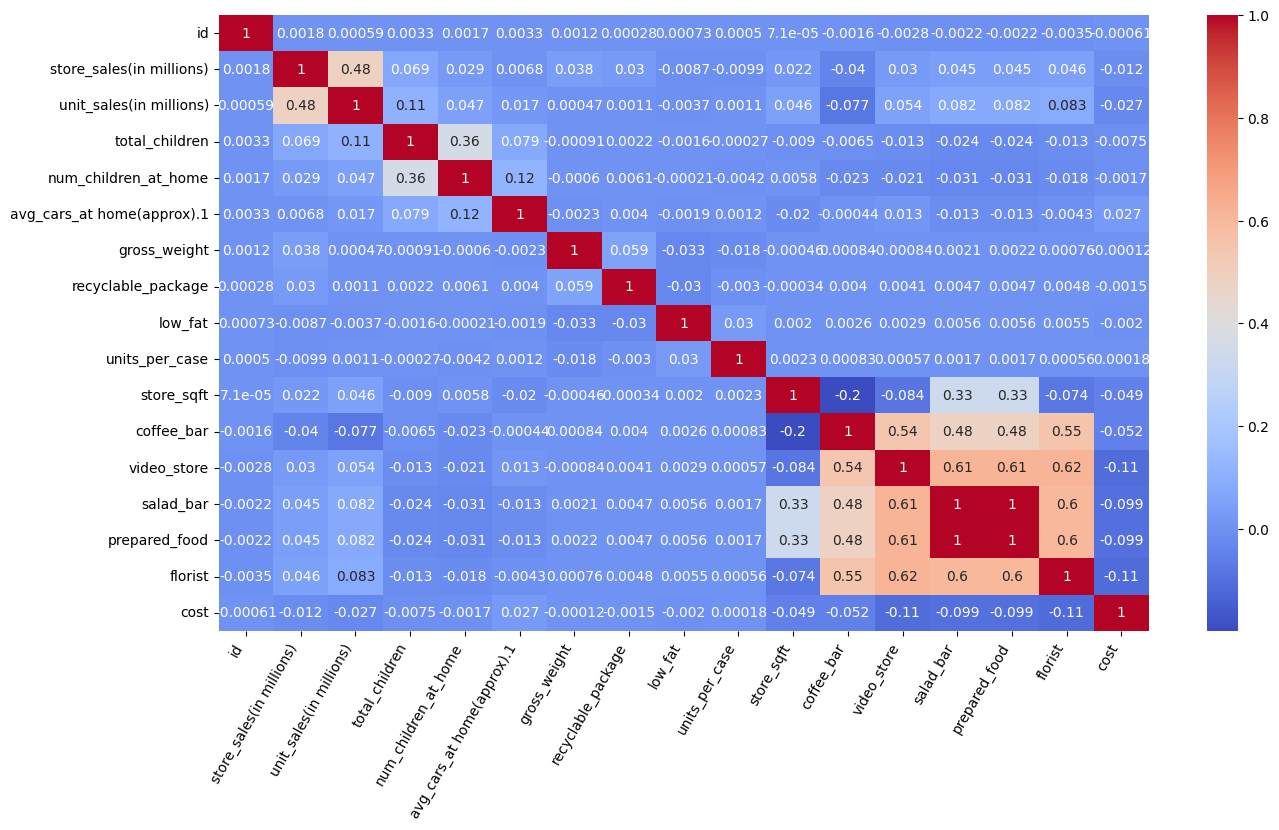

In [5]:
# 4. Корреляционный анализ
corr_matrix = data.corr()

plt.figure(figsize=(15, 8))  
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

plt.xticks(rotation=60, ha='right')  
plt.yticks(rotation=0) 
plt.show()


### 5. Разделение данных

In [8]:

# 5. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6. Обучение моделей

#### OLS

In [11]:
# Model 1: OLS (statsmodels)
X_train_sm = sm.add_constant(X_train)  # Добавляем константу для statsmodels
X_test_sm = sm.add_constant(X_test)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())
y_pred_ols = ols_model.predict(X_test_sm)

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     547.9
Date:                Tue, 11 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:06:43   Log-Likelihood:            -1.0616e+06
No. Observations:              230882   AIC:                         2.123e+06
Df Residuals:                  230865   BIC:                         2.123e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

#### Linear Regression (scikit-learn)

In [40]:
# Model 2: Linear Regression (scikit-learn)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

### 7. Оценка качества моделей

In [47]:
# Оценка

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}

# Оценка OLS
ols_metrics = evaluate_model(y_test, y_pred_ols)

# Оценка LinearRegression
lr_metrics = evaluate_model(y_test, y_pred)

# Выводим результаты
print("OLS statsmodels:", ols_metrics)
print("LinearRegression sklearn:", lr_metrics)


OLS statsmodels: {'MAE': 20.55075679375059, 'MSE': 581.2814067842338, 'RMSE': np.float64(24.109778240046793), 'MAPE': 0.2262011709572595}
LinearRegression sklearn: {'MAE': 20.550756793765565, 'MSE': 581.2814067833566, 'RMSE': np.float64(24.1097782400286), 'MAPE': 0.22620117096203904}


In [13]:
# 7. Оценка качества моделей
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mae, mse, rmse, mape

mae, mse, rmse, mape = evaluate_model(y_test, y_pred)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}")

MAE: 20.536673518121233, MSE: 580.8471008217565, RMSE: 24.100769714300753, MAPE: 0.22602810210191326


### 8. Визуализация коэффициентов

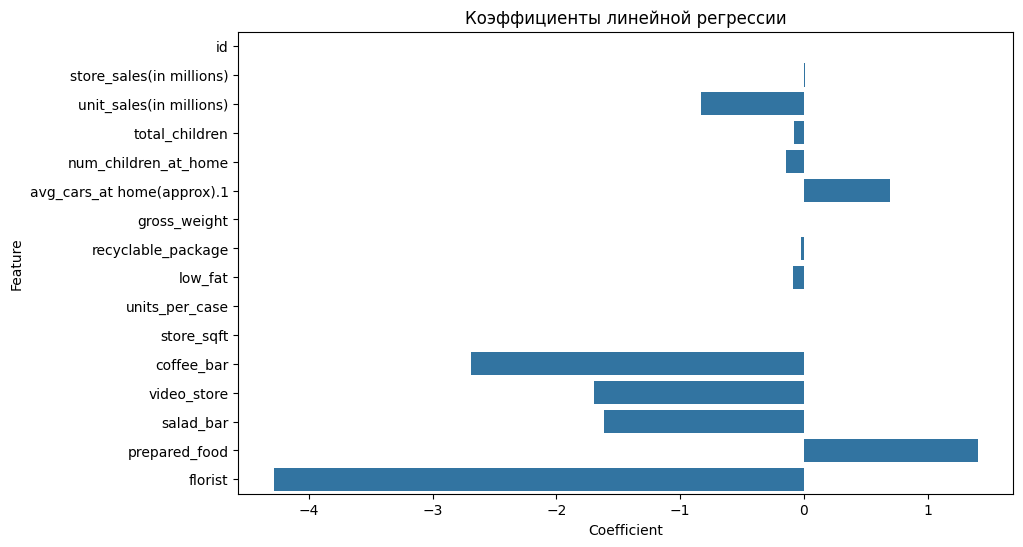

In [14]:
# 8. Визуализация коэффициентов
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": lr_model.coef_})
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df)
plt.title("Коэффициенты линейной регрессии")
plt.show()


### Улучшение модели  

Удалим лишние столбцы  (Признаки)

Уменьшим выбросы

Выбранные признаки: Index(['avg_cars_at home(approx).1', 'store_sqft', 'coffee_bar', 'video_store',
       'salad_bar', 'prepared_food', 'florist'],
      dtype='object')


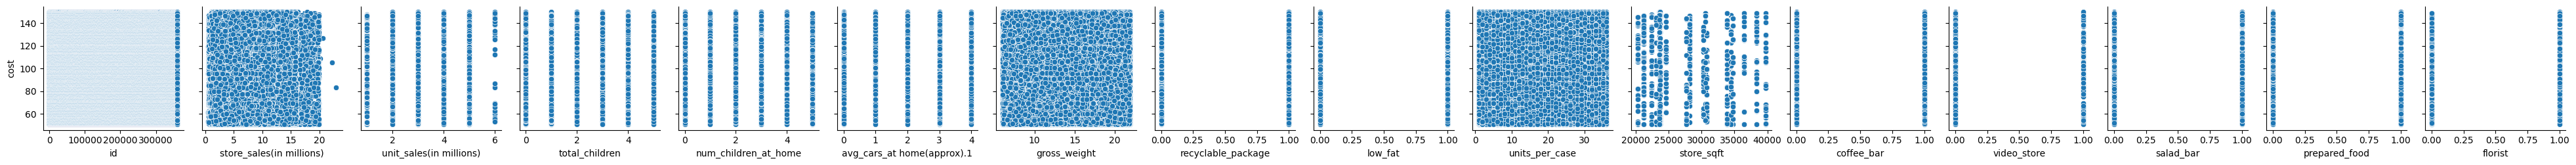

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
id,1.000000,0.001051,0.000300,0.002480,0.000838,0.002492,0.000806,0.000226,0.000600,0.000311,-0.000382,-0.001317,-0.002283,-0.001811,-0.001810,-0.002885,-0.000472
store_sales(in millions),0.001051,1.000000,0.356967,0.042448,0.012161,0.003827,0.028012,0.025510,-0.008446,-0.008963,0.014384,-0.034881,0.026046,0.039639,0.039665,0.040803,-0.008605
unit_sales(in millions),0.000300,0.356967,1.000000,0.091683,0.026229,0.013622,-0.000084,0.000490,-0.004176,0.000207,0.026722,-0.062080,0.042902,0.065112,0.065142,0.065483,-0.018202
total_children,0.002480,0.042448,0.091683,1.000000,0.244703,0.060307,-0.000573,0.001814,-0.001453,-0.000054,-0.006418,-0.006349,-0.011245,-0.020434,-0.020429,-0.010596,-0.005371
num_children_at_home,0.000838,0.012161,0.026229,0.244703,1.000000,0.084794,0.000245,0.005178,-0.000533,-0.004107,0.007323,-0.028996,-0.019457,-0.031446,-0.031410,-0.023684,-0.002534
avg_cars_at home(approx).1,0.002492,0.003827,0.013622,0.060307,0.084794,1.000000,-0.001566,0.003715,-0.001768,0.000967,-0.010462,-0.000789,0.014101,-0.008475,-0.008410,-0.001376,0.017627
gross_weight,0.000806,0.028012,-0.000084,-0.000573,0.000245,-0.001566,1.000000,0.048916,-0.027524,-0.010019,-0.000229,0.000651,-0.000686,0.001820,0.001851,0.000758,-0.000152
recyclable_package,0.000226,0.025510,0.000490,0.001814,0.005178,0.003715,0.048916,1.000000,-0.030025,-0.002582,-0.000242,0.004037,0.004129,0.004674,0.004672,0.004849,-0.001228
low_fat,0.000600,-0.008446,-0.004176,-0.001453,-0.000533,-0.001768,-0.027524,-0.030025,1.000000,0.023738,0.001954,0.002622,0.002893,0.005602,0.005567,0.005540,-0.001555
units_per_case,0.000311,-0.008963,0.000207,-0.000054,-0.004107,0.000967,-0.010019,-0.002582,0.023738,1.000000,0.001665,0.000632,0.000544,0.001429,0.001428,0.000529,0.000137


In [28]:

X = data.drop(columns=['cost'])
y = data['cost']

selector = SelectKBest(score_func=f_regression, k=7)  # Выбираем  лучшие признаки
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Выбранные признаки:", selected_features)



sns.pairplot(data, y_vars=['cost'], x_vars=data.columns.drop('cost'))
plt.show()



data.corr(method='spearman')  # Для монотонных зависимостей
data.corr(method='kendall')   # Для непараметрических данных


### Выбранные признаки
'avg_cars_at home(approx).1', 'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist'

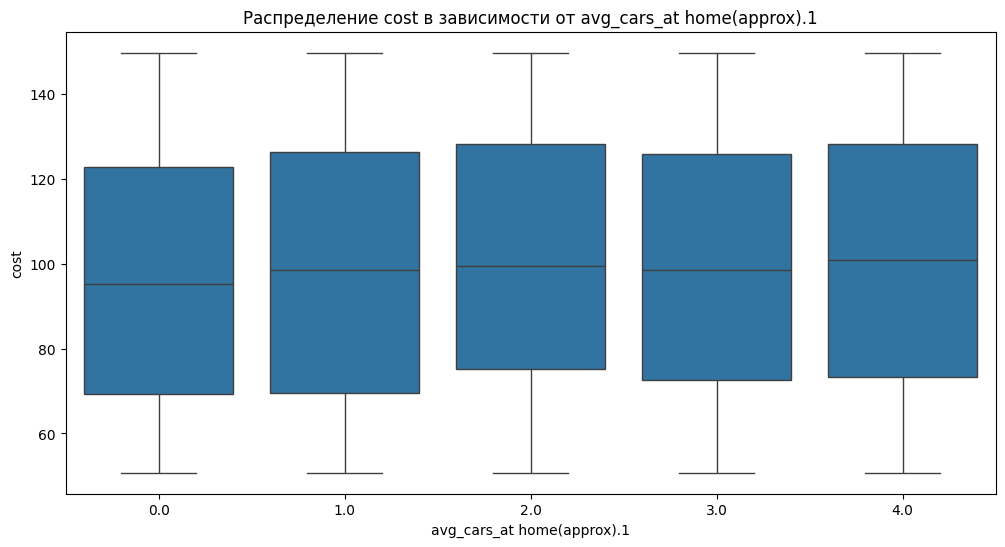

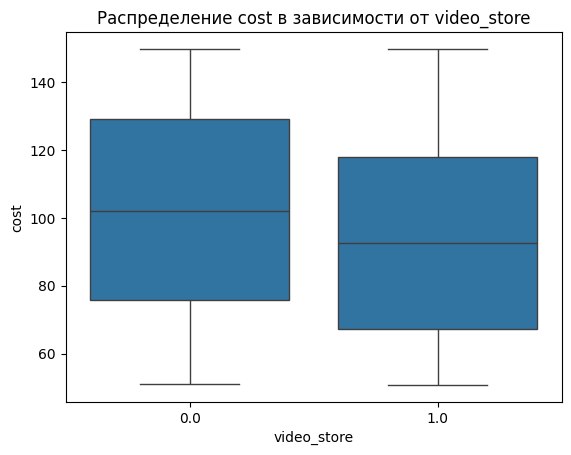

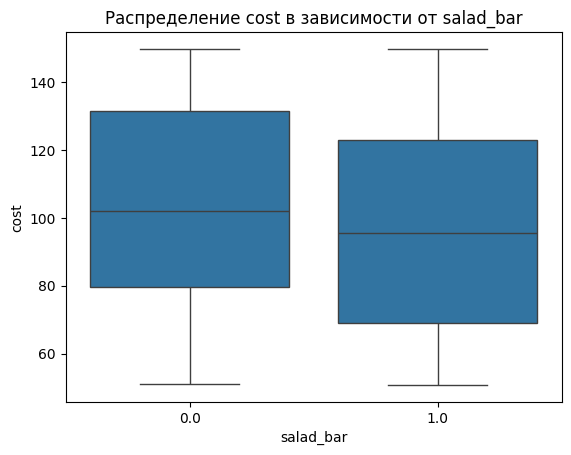

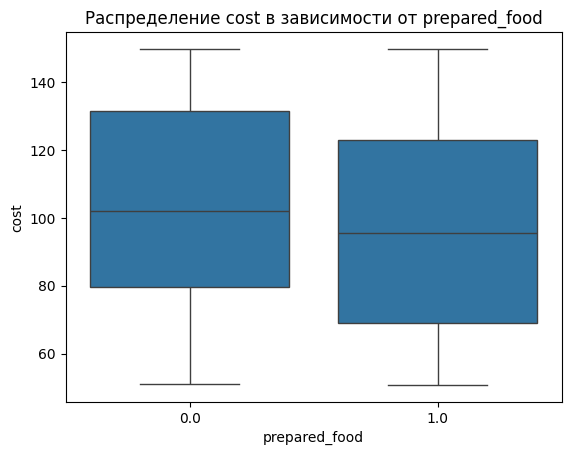

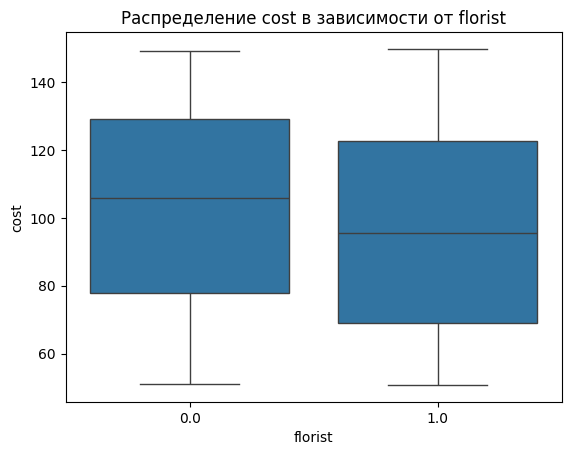

In [12]:
plt.figure(figsize=(12, 6))
for feature in ['avg_cars_at home(approx).1', 'video_store', 'salad_bar', 'prepared_food', 'florist']:
    sns.boxplot(x=data[feature], y=data['cost'])
    plt.title(f"Распределение cost в зависимости от {feature}")
    plt.show()


In [48]:
# Определяем признаки и целевую переменную
# Убираем лишние столбцы

X = data[['avg_cars_at home(approx).1', 'store_sqft', 'coffee_bar', 'video_store',
          'salad_bar', 'prepared_food', 'florist']]
y = data['cost']


# Анализ и обработка выбросов 
lower_bound = y.quantile(0.2)
upper_bound = y.quantile(0.8)
y = y[(y >= lower_bound) & (y <= upper_bound)]
X = X.loc[y.index]



# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
# Обучение модели OLS

# Добавляем константу к признакам
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Обучаем модель
model_ols = sm.OLS(y_train, X_train_sm).fit()

# Выводим статистику модели
print(model_ols.summary())
y_pred_ols = model_ols.predict(X_test_sm)

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     613.3
Date:                Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:19:32   Log-Likelihood:            -7.5860e+05
No. Observations:              174869   AIC:                         1.517e+06
Df Residuals:                  174861   BIC:                         1.517e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [50]:
# Обучение LinearRegression

# Обучение модели
lr = LinearRegression()
lr.fit(X_train, y_train)

# Предсказания
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)


In [51]:
# Оценка

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}

# Оценка OLS
ols_metrics = evaluate_model(y_test, y_pred_ols)

# Оценка LinearRegression
lr_metrics = evaluate_model(y_test, y_pred_test)

# Выводим результаты
print("OLS statsmodels:", ols_metrics)
print("LinearRegression sklearn:", lr_metrics)


OLS statsmodels: {'MAE': 15.488868074731949, 'MSE': 339.388019386704, 'RMSE': np.float64(18.4224867861726), 'MAPE': 0.16457992408829675}
LinearRegression sklearn: {'MAE': 15.488868074719266, 'MSE': 339.3880193869322, 'RMSE': np.float64(18.422486786178794), 'MAPE': 0.16457992409114255}


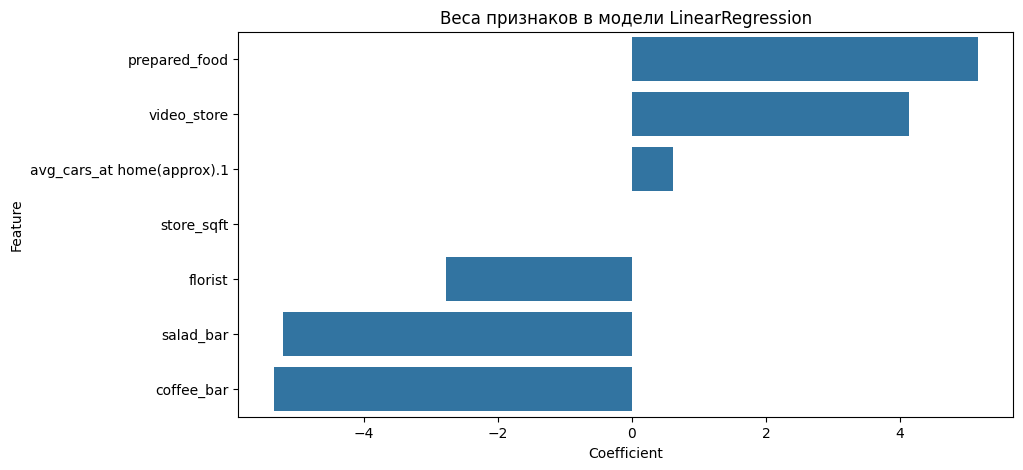

In [52]:
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficient": lr.coef_})
coefficients = coefficients.sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Coefficient", y="Feature", data=coefficients)
plt.title("Веса признаков в модели LinearRegression")
plt.show()
